# COMP4318/5318 Assignment 2: Image Classification

### Group number: ...  , SID1: ... , SID2: ..., SID3: ... 

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [ ]:
import keras
import kerastuner as kt
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split

## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [32]:
# Load the dataset training and test sets as numpy arrays
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

#normalize the data
X_train = X_train / 255
X_test = X_test / 255

# convert images to grayscale for feature extraction
X_train_gray = np.array([rgb2gray(image) for image in X_train])
X_test_gray = np.array([rgb2gray(image) for image in X_test])

#convert labels to one-hot encoding
y_train_onehot = keras.utils.to_categorical(y_train, 9)
y_test_onehot = keras.utils.to_categorical(y_test, 9)

#split training sets into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train_gray, X_val_gray, y_train_onehot, y_val_onehot = train_test_split(X_train_gray, y_train_onehot, test_size=0.2, random_state=42)

### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

X_train shape: (25600, 28, 28, 3)
X_train_gray shape: (25600, 28, 28)
y_train shape: (25600,)
y_train examples: [5 6 7 6 8]
y_train_onehot shape: (25600, 9)
y_train_onehot examples: [[0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]


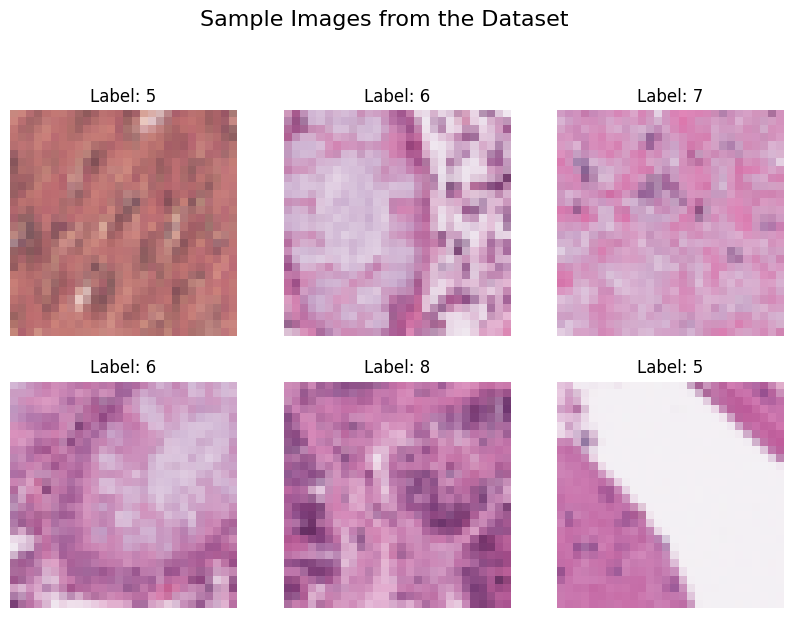

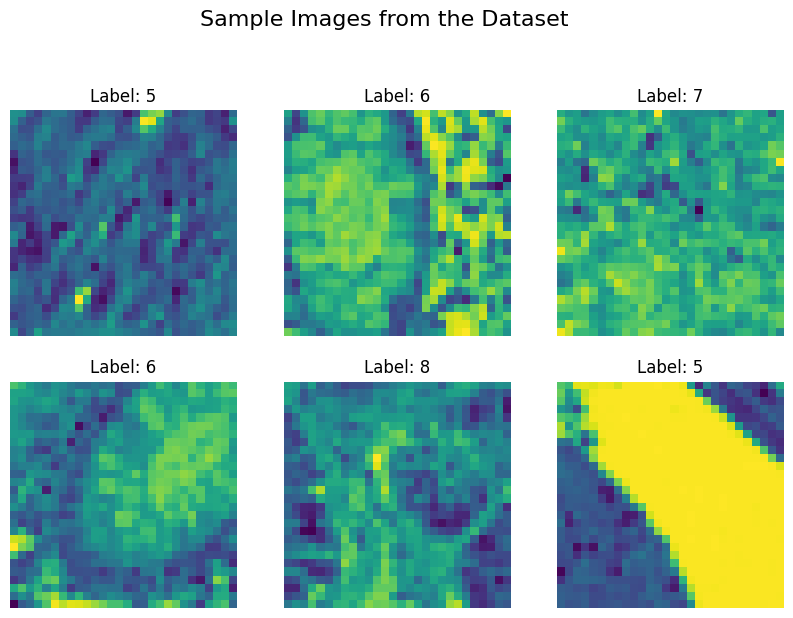

In [33]:
print("X_train shape:", X_train.shape)
print("X_train_gray shape:", X_train_gray.shape)
print("y_train shape:", y_train.shape)
print("y_train examples:", y_train[:5])
print("y_train_onehot shape:", y_train_onehot.shape)
print("y_train_onehot examples:" , y_train_onehot[:5])

def plot_images(title, dataset:np.ndarray, labels:np.ndarray, num_images:int=6):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(dataset[i])
        plt.axis('off')
        plt.title(f"Label: {labels[i]}")
    plt.suptitle('Sample Images from the Dataset', fontsize=16)
    plt.show()

plot_images('Sample Color Images', X_train, y_train, num_images=6)
plot_images('Sample Grayscale images', X_train_gray, y_train, num_images=6)


## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

### Fully connected neural network

In [ ]:
def build_fc_model(hp):
    """Builds a fully connected model with tunable hyperparametes."""

    # tunable hyperparameters
    num_layers = hp.Int('num_layers', min_value=2, max_value=5)
    num_units = hp.Int('num_units', min_value=64, max_value=512, step=64)
    dropout_rate = hp.Float('dropout_rate', 0, 0.5, step=0.1)
    learning_rate = hp.Choice('learning_rate', [1e-1, 1e-2, 1e-3, 1e-4])

    
    model = keras.models.Sequential([
        keras.layers.Input(shape=(28, 28, 3)),
        keras.layers.Flatten(),
    ])

    for _ in range(num_layers):
        model.add(keras.layers.Dense(units=num_units, activation='relu'
        ))
        model.add(keras.layers.Dropout(rate=dropout_rate))
    
    model.add(keras.layers.Dense(units=9, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

### Convolutional neural network

## 3. Hyperparameter tuning

In [ ]:
import os
import shutil

def tune_nn_model(model, model_type: str):
    """Tune the neural network model using Keras Tuner. 
    Args:
        model: The model to be tuned.
        model_type: The type of the model (e.g., 'fc', 'cnn', etc.)."""

    # Set up the log directory for TensorBoard
    log_dir =f'tuning_logs/{model_type}'
    if os.path.exists(log_dir):
        # Remove the previous log directory if it exists
        shutil.rmtree(log_dir, ignore_errors=True)
    os.makedirs(log_dir)

    # Remove the previous keras_tuner directory if it exists
    if os.path.exists('keras_tuner'):
        shutil.rmtree('keras_tuner', ignore_errors=True)

    # Define the hypermodel
    tuner = kt.Hyperband(
        model,
        objective='val_accuracy',
        max_epochs=10,
        factor=2,
        directory='keras_tuner',
        project_name=model_type,
    )
    # TensorBoard callback for logging and visualization of the tuning process
    tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) 
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    
    # Start the parameter search
    tuner.search_space_summary()
    tuner.search(
        X_train, y_train_onehot,
        epochs=30,
        validation_data=(X_val, y_val_onehot),
        verbose=1,
        callbacks=[tensorboard, early_stopping],
    )

    # Get the best hyperparameters and build the best model
    best_params = tuner.get_best_hyperparameters()[0]
    best_model = tuner._build_hypermodel(best_params)
    
    tuner.results_summary(num_trials=1)
    
    return best_model, best_params


### Algorithm of choice from first six weeks of course

### Fully connected neural network

In [36]:
# tune the model to find the best hyperparameters
best_model, best_params = tune_nn_model(build_fc_model, 'fc')

# train the best model
best_model.fit(
    X_train, y_train_onehot,
    epochs=10,
    batch_size=16,
    validation_data=(X_val, y_val_onehot),
    verbose=1
)

# evaluate the model
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_onehot)

best_model.save('best_models/best_fc_model.keras')
best_model.summary()

Trial 46 Complete [00h 00m 55s]
val_accuracy: 0.14546875655651093

Best val_accuracy So Far: 0.5357812643051147
Total elapsed time: 00h 08m 41s
Results summary
Results in keras_tuner/fc
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 0031 summary
Hyperparameters:
num_layers: 5
num_units: 320
dropout_rate: 0.0
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 5
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0027
Score: 0.5357812643051147
Epoch 1/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4784 - loss: 1.3934 - val_accuracy: 0.4975 - val_loss: 1.3581
Epoch 2/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4958 - loss: 1.3388 - val_accuracy: 0.4816 - val_loss: 1.3555
Epoch 3/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5026 - loss: 1.3100 - val_accuracy: 0.5308 - val_loss: 1.2635
Epoch 4/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5296 - loss: 1.2475 - val_accuracy: 0.5561 - val_loss: 1.1940

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 320)            │       752,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 320)            │       102,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 320)            │       102,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 320)            │       102,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 320)            │       102,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │         2,889 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,500,189 (13.35 MB)

 Trainable params: 1,166,729 (4.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,333,460 (8.90 MB)

### Convolutional neural network

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

### Fully connected neural network

In [37]:
fc_model = keras.models.load_model('best_models/best_fc_model.keras')

# Evaluate the model on the test set
test_loss, test_accuracy = fc_model.evaluate(X_test, y_test_onehot)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6111 - loss: 1.0015
Test Loss: 1.0027
Test Accuracy: 0.6071


### Convolutional neural network